In [ ]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.9 MB/s eta 0:00:00


In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rootFolder = '/content/drive/My Drive/Colab Notebooks/Face Detection'

framesFolder = os.path.join(rootFolder, 'train')
csvPath = os.path.join(rootFolder, 'annotations.csv')

print(f"Dataset Root: {rootFolder}")

Dataset Root: /content/drive/My Drive/Colab Notebooks/Face Detection


In [ ]:
def extractBboxFromXml(xmlPath):
    tree = ET.parse(xmlPath)
    root = tree.getroot()

    # Extract image size
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    records = []

    # Extract bounding boxes for all objects
    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')

        # VOC format: (xmin, ymax, xmax, ymax)
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # The image name is derived from the XML filename
        imgName = os.path.basename(xmlPath).replace('.xml', '.jpg')

        records.append({
            'filename': imgName,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return records

In [ ]:
allRecords = []
# Filtering files in the train to only get XML files
xmlFiles = [f for f in os.listdir(framesFolder) if f.endswith('.xml')]

print(f"Found {len(xmlFiles)} annotation files in {framesFolder}.")

for xmlFile in tqdm(xmlFiles):
    xmlPath = os.path.join(framesFolder, xmlFile)
    allRecords.extend(extractBboxFromXml(xmlPath))

# Creating DataFrame
df = pd.DataFrame(allRecords)

# Target classes in xml
targetClasses = ['jerry', 'tom']

# Filter DF using the list of target class names
dfFaces = df[df['class'].isin(targetClasses)].copy()
dfFaces['class'] = 'face'

# Saving the final CSV file
dfFaces.to_csv(csvPath, index=False)
print(f"\nCSV successfully created and saved to: {csvPath}")
print(f"Total face annotations: {len(dfFaces)}")
print("\nFirst 5 rows of the generated CSV:")
print(dfFaces.head())

Found 301 annotation files in /content/drive/My Drive/Colab Notebooks/Face Detection/train.


100%|██████████| 301/301 [00:08<00:00, 35.09it/s] 



CSV successfully created and saved to: /content/drive/My Drive/Colab Notebooks/Face Detection/annotations.csv
Total face annotations: 321

First 5 rows of the generated CSV:
       filename  width  height class  xmin  ymin  xmax  ymax
0  frame236.jpg   1280     720  face   139    93   494   322
1  frame100.jpg   1280     720  face   313   171   613   383
2   frame34.jpg   1280     720  face   692    91  1020   304
3  frame204.jpg   1280     720  face   429    54   804   279
4  frame192.jpg   1280     720  face   417    62   730   284


In [ ]:
yoloData = os.path.join(rootFolder, 'yoloData')
os.makedirs(yoloData, exist_ok=True)

# Creating folders for YOLO structure
yoloImages = os.path.join(yoloData, 'images')
yoloLabels = os.path.join(yoloData, 'labels')

# Subdirectories for train, val, test
for sub in ['train', 'val', 'test']:
    os.makedirs(os.path.join(yoloImages, sub), exist_ok=True)
    os.makedirs(os.path.join(yoloLabels, sub), exist_ok=True)

className = 'face'
classId = 0

def vocToYolo(box, w, h):
    xmin, ymin, xmax, ymax = box
    boxW = xmax - xmin
    boxH = ymax - ymin
    xCenter = xmin + (boxW / 2)
    yCenter = ymin + (boxH / 2)

    xCenterNorm = xCenter / w
    yCenterNorm = yCenter / h
    widthNorm = boxW / w
    heightNorm = boxH / h

    return f"{classId} {xCenterNorm:.6f} {yCenterNorm:.6f} {widthNorm:.6f} {heightNorm:.6f}"

In [ ]:
# Data Spliting
allImages = dfFaces['filename'].unique()
trainFiles, tempFiles = train_test_split(allImages, test_size=0.2, random_state=42)
valFiles, testFiles = train_test_split(tempFiles, test_size=0.5, random_state=42)

splitMap = {
    'train': trainFiles,
    'val': valFiles,
    'test': testFiles
}

print(f"\nTotal images: {len(allImages)}")
print(f"Train images: {len(trainFiles)}")


Total images: 301
Train images: 240


In [ ]:
# Converting annotations and copying files
for splitName, files_list in splitMap.items():
    print(f"Processing {splitName} set...")

    imgSplitDir = os.path.join(yoloImages, splitName)
    labelSplitDir = os.path.join(yoloLabels, splitName)

    for imgFile in tqdm(files_list):
        # Copying image
        srcImgPath = os.path.join(framesFolder, imgFile)
        dstImgPath = os.path.join(imgSplitDir, imgFile)
        shutil.copy(srcImgPath, dstImgPath)

        # Creating yolo annotation file
        labelFile = imgFile.replace('.jpg', '.txt')
        labelPath = os.path.join(labelSplitDir, labelFile)

        image_annotations = dfFaces[dfFaces['filename'] == imgFile]
        width = image_annotations['width'].iloc[0]
        height = image_annotations['height'].iloc[0]

        yoloLines = []
        for index, row in image_annotations.iterrows():
            vocBox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
            yoloLine = vocToYolo(vocBox, width, height)
            yoloLines.append(yoloLine)

        with open(labelPath, 'w') as f:
            f.write('\n'.join(yoloLines))

print("\nData successfully converted to yolo format and split into train/val/test")

Processing train set...


100%|██████████| 240/240 [02:31<00:00,  1.58it/s]


Processing val set...


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


Processing test set...


100%|██████████| 31/31 [00:18<00:00,  1.70it/s]


Data successfully converted to yolo format and split into train/val/test


In [ ]:
# Creating data.yaml file
yoloConfigPath = os.path.join(yoloData, 'data.yaml')

yamlContent = f"""
# YOLOv5 Custom Dataset Configuration
train: {os.path.join(yoloImages, 'train')}
val: {os.path.join(yoloImages, 'val')}
test: {os.path.join(yoloImages, 'test')}

# Number of classes
nc: 1

# Class names
names: ['face']
"""

with open(yoloConfigPath, 'w') as f:
    f.write(yamlContent)

print(f"Created yolo configuration file at: {yoloConfigPath}")
print("\ndata.yaml Content")
print(yamlContent)

Created yolo configuration file at: /content/drive/My Drive/Colab Notebooks/Face Detection/yoloData/data.yaml

data.yaml Content

# YOLOv5 Custom Dataset Configuration
train: /content/drive/My Drive/Colab Notebooks/Face Detection/yoloData/images/train
val: /content/drive/My Drive/Colab Notebooks/Face Detection/yoloData/images/val
test: /content/drive/My Drive/Colab Notebooks/Face Detection/yoloData/images/test

# Number of classes
nc: 1

# Class names
names: ['face']



In [ ]:
model = YOLO("yolov8n.pt")

# Defining paths and parameters
epochsCount = 50
imgSize = 640
batchSize = 8

# Defining the directory where results will be saved
projectDir = os.path.join(rootFolder, 'yolov8_training_results')
experimentName = 'tom_jerry_v8_face_detector'


print(f"tarting YOLOv8 Training for {epochsCount} epochs...")

results = model.train(
    data = yoloConfigPath,
    epochs = epochsCount,
    imgsz = imgSize,
    batch = batchSize,
    project = projectDir,
    name = experimentName,
    patience=50,
    device=0
)

print("\nTraining complete")

tarting YOLOv8 Training for 50 epochs...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/Colab Notebooks/Face Detection/yoloData/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tom_jerry_v8_face_detector, nbs=64, nms=False, opset=Non


YOLOv8 Model Training Results & Plots

--- 1. Metrics Plot (Loss, Precision, Recall, mAP) ---


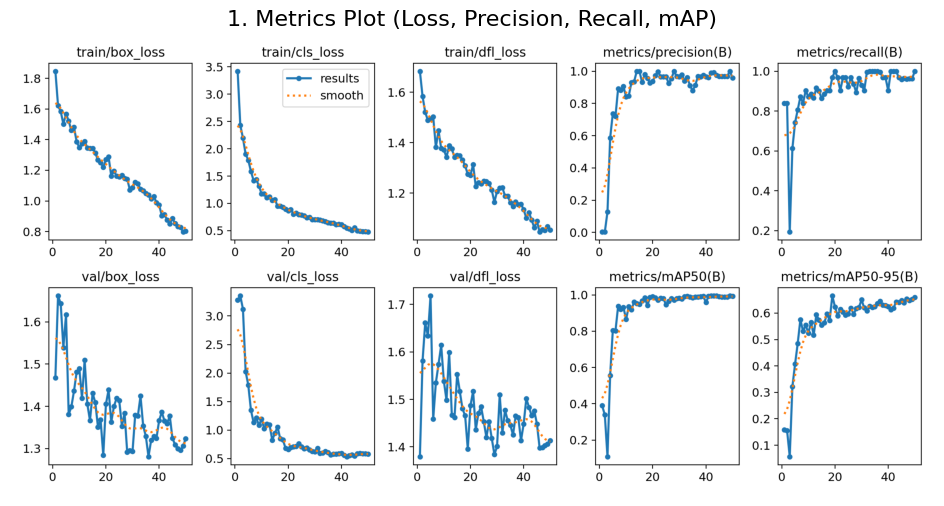

Plot not found: 2. F1-Curve Plot

--- 3. Confusion Matrix ---


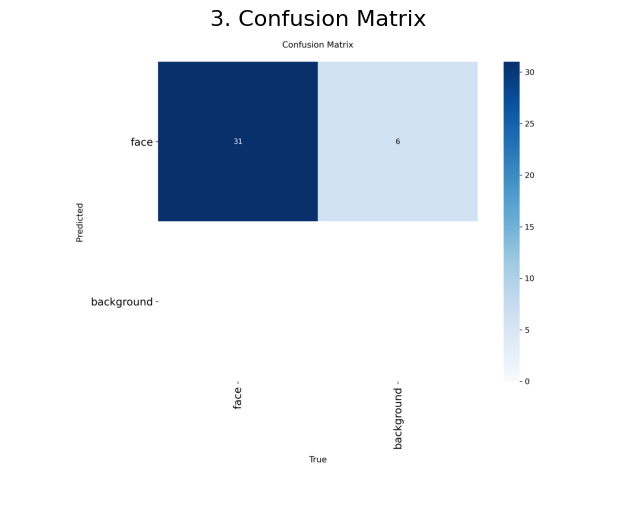


--- Final Validation Metrics ---
[    0.66088]


In [ ]:
resultsPath = os.path.join(projectDir, experimentName)

if not os.path.exists(resultsPath):
    print("Training results directory not found. Please check the training output.")
else:
    print("\nYOLOv8 Model Training Results & Plots")

    # Defining paths to the automatically generated plots
    plots = {
        "1. Metrics Plot (Loss, Precision, Recall, mAP)": os.path.join(resultsPath, 'results.png'),
        "2. F1-Curve Plot": os.path.join(resultsPath, 'F1_curve.png'),
        "3. Confusion Matrix": os.path.join(resultsPath, 'confusion_matrix.png')
    }

    # Displaying the plots
    for title, plotPath in plots.items():
        if os.path.exists(plotPath):
            print(f"\n--- {title} ---")
            plt.figure(figsize=(12, 6))
            try:
                img = mpimg.imread(plotPath)
                plt.imshow(img)
                plt.title(title, fontsize=16)
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"Error loading {plotPath}: {e}")
        else:
            print(f"Plot not found: {title}")

# Validation Metrics
print("\n--- Final Validation Metrics ---")
print(results.box.maps)

In [ ]:
rootFolder = '/content/drive/My Drive/Colab Notebooks/Face Detection'
framesFolder = os.path.join(rootFolder, 'train')

projectDir = os.path.join(rootFolder, 'yolov8_training_results')
experimentName = 'tom_jerry_v8_face_detector'
resultsPath = os.path.join(projectDir, experimentName)

weightsPath = os.path.join(resultsPath, 'weights', 'best.pt')
yoloData = os.path.join(rootFolder, 'yoloData')
testImgDir = os.path.join(yoloData, 'images', 'test')

if not os.path.exists(weightsPath):
    print(f"ERROR: Best weights file not found at {weightsPath}")
    print("Please ensure Section 5 (Training) ran successfully.")
else:
    print(f"Found weights at: {weightsPath}")
    # Load the trained model
    trainedModel = YOLO(weightsPath)

Found weights at: /content/drive/My Drive/Colab Notebooks/Face Detection/yolov8_training_results/tom_jerry_v8_face_detector/weights/best.pt


Running inference on custom image: /content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/train/angry/frame20.jpg
Results saved to /content/runs/detect/predict
Output directory: /content/runs/detect/predict
Displaying detection result using OpenCV:


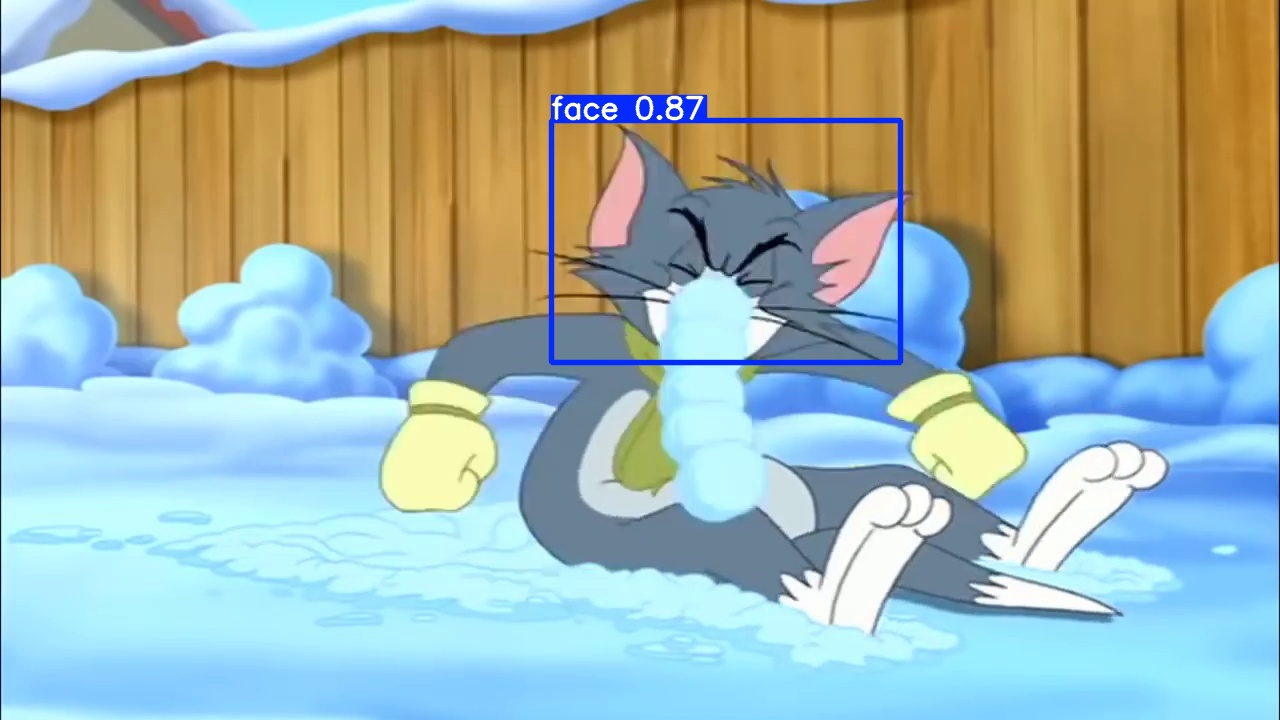

In [ ]:
testImgPath = '/content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/train/angry/frame20.jpg'
testImgName = os.path.basename(testImgPath)

if os.path.exists(testImgPath):
    print("Running inference on custom image:", testImgPath)

    results = trainedModel.predict(
        source=testImgPath,
        conf=0.25,
        save=True
    )

    if results:
        out_dir = results[0].save_dir
        print("Output directory:", out_dir)

        detected_path = os.path.join(out_dir, testImgName)

        if os.path.exists(detected_path):
            image = cv2.imread(detected_path)

            if image is None:
                print("cv2 could not read detected image.")
            else:
                print("Displaying detection result using OpenCV:")
                cv2_imshow(image)

        else:
            print("Detected image not found with expected filename:", detected_path)
            print("Files available:", os.listdir(out_dir))

    else:
        print("Model returned no results.")
else:
    print("Image not found:", testImgPath)


**Emotion Detection Model**

In [ ]:
# Path for emotions folder
basePath = '/content/drive/MyDrive/Colab Notebooks/Emotion Detection'

#label mapping
emotionToLabel = {
    'angry': 0,
    'happy': 1,
    'sad': 2,
    'surprised': 3,
    'unknown': 4
}

data = []

# Traversing over each folder
for emotion, label in emotionToLabel.items():
    folderPath = os.path.join(basePath, emotion)
    if not os.path.exists(folderPath):
        continue

    for file in os.listdir(folderPath):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        imagePath = os.path.join(folderPath, file)
        imagePath = os.path.relpath(imagePath, start='/content')

        data.append({
            'frameID': imagePath,
            'emotion': emotion,
            'label': label
        })

#converting to dataframe
df = pd.DataFrame(data)

#saving in csv file
csvOutputPath = '/content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/large-dataset-emotion-detection-labels.csv'
df.to_csv(csvOutputPath, index=False)

print(f"CSV saved to: {csvOutputPath}")

CSV saved to: /content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/large-dataset-emotion-detection-labels.csv


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, csvPath, transform=None):
        self.data = pd.read_csv(csvPath)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgPath = self.data.iloc[idx]['frameID']
        label = int(self.data.iloc[idx]['label'])
        image = Image.open(imgPath).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

#transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#Loading dataset and dataLoader
csvPath = '/content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/large-dataset-emotion-detection-labels.csv'
dataset = EmotionDataset(csvPath, transform=transform)
dataLoader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

#Loading pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 5)

#Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#Training loop
numEpochs = 10
for epoch in range(numEpochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataLoader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{numEpochs}] | Accuracy: {acc:.2f}% | Loss: {total_loss/len(dataLoader):.4f}")

#Saving trained model
savePath = '/content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/large-dataset-tom-and-jerry-emotion-detection-mobilenetv2.pth'
torch.save(model.state_dict(), savePath)
print(f"Model saved to: {savePath}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 85.0MB/s]
100%|██████████| 221/221 [03:27<00:00,  1.07it/s]


Epoch [1/10] | Accuracy: 65.30% | Loss: 0.9371


100%|██████████| 221/221 [00:13<00:00, 16.31it/s]


Epoch [2/10] | Accuracy: 84.67% | Loss: 0.4621


100%|██████████| 221/221 [00:13<00:00, 16.75it/s]


Epoch [3/10] | Accuracy: 91.37% | Loss: 0.2647


100%|██████████| 221/221 [00:13<00:00, 16.49it/s]


Epoch [4/10] | Accuracy: 94.15% | Loss: 0.1941


100%|██████████| 221/221 [00:13<00:00, 16.65it/s]


Epoch [5/10] | Accuracy: 95.12% | Loss: 0.1533


100%|██████████| 221/221 [00:13<00:00, 16.54it/s]


Epoch [6/10] | Accuracy: 96.82% | Loss: 0.1034


100%|██████████| 221/221 [00:13<00:00, 16.67it/s]


Epoch [7/10] | Accuracy: 96.65% | Loss: 0.1204


100%|██████████| 221/221 [00:13<00:00, 16.70it/s]


Epoch [8/10] | Accuracy: 97.16% | Loss: 0.0930


100%|██████████| 221/221 [00:13<00:00, 16.39it/s]


Epoch [9/10] | Accuracy: 97.16% | Loss: 0.1249


100%|██████████| 221/221 [00:13<00:00, 16.76it/s]


Epoch [10/10] | Accuracy: 97.61% | Loss: 0.0798
Model saved to: /content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/large-dataset-tom-and-jerry-emotion-detection-mobilenetv2.pth


Face detected at BBox (522, 40) to (797, 215): Predicted Emotion: angry


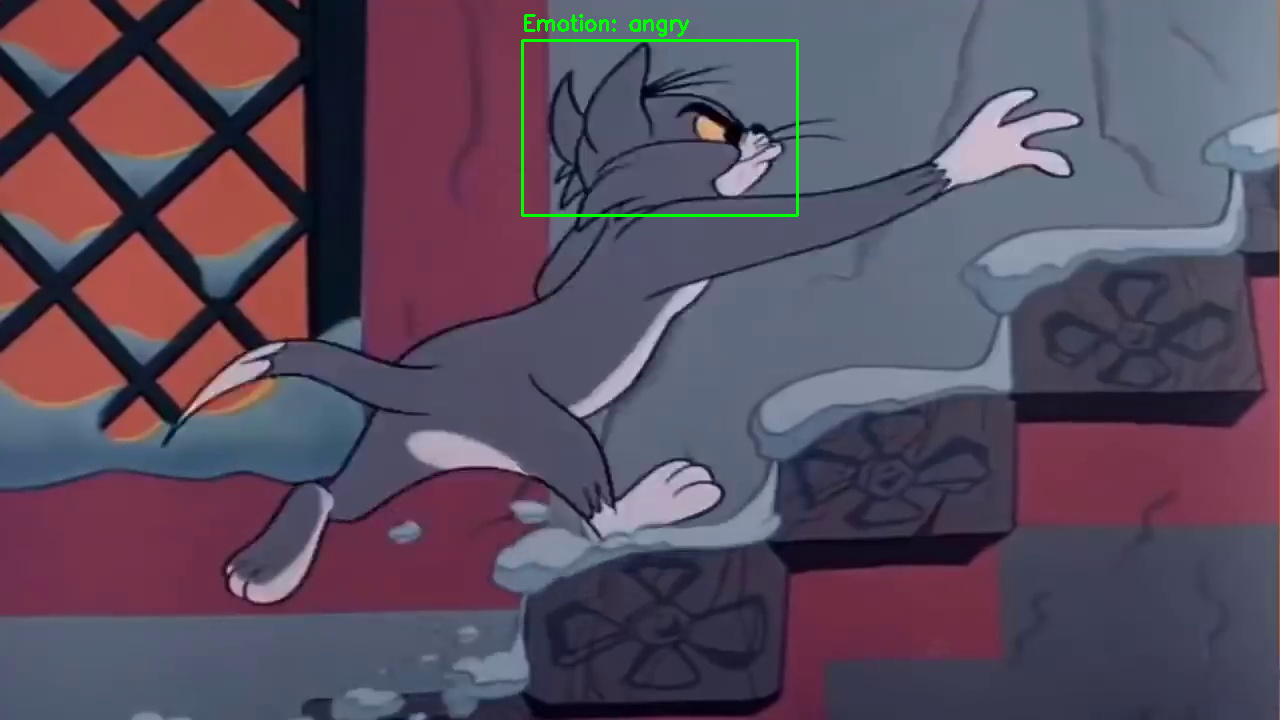

Image with detections and emotions displayed above.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading the MobileNetV2 model
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 5)
emotionWeights = '/content/drive/MyDrive/Colab Notebooks/TomAndJerryEmotionsCVProject/large-dataset-tom-and-jerry-emotion-detection-mobilenetv2.pth'
model.load_state_dict(torch.load(emotionWeights, map_location=device))
model.to(device)
model.eval()

emotions = ['angry', 'happy', 'sad', 'surprised', 'unknown']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def predictEmotion(img):
    facePil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #Applying emotion model transforms
    inputTensor = transform(facePil).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(inputTensor)
        predictedIdx = torch.argmax(output, dim=1).item()
        predictedEmotion = emotions[predictedIdx]

    return predictedEmotion

def detectionAndPrediction(imgPath, confThreshold=0.5):
    #Loading original img
    image = cv2.imread(imgPath)
    if image is None:
        print(f"Error: Image not found at {imgPath}. Check the path and file integrity.")
        return

    #Running trained yolo model
    results = trainedModel(imgPath, conf=confThreshold, verbose=False)

    processedImg = image.copy()

    for r in results:
        #Getting integer bounding box coordinates
        boxes = r.boxes.xyxy.cpu().numpy().astype(int)

        for box in boxes:
            x1, y1, x2, y2 = box

            # Add padding to replicate the context present in your emotion training data.
            padding = 10
            cropX1 = max(0, x1 - padding)
            cropY1 = max(0, y1 - padding)
            cropX2 = min(image.shape[1], x2 + padding)
            cropY2 = min(image.shape[0], y2 + padding)

            croppedFace = image[cropY1:cropY2, cropX1:cropX2]

            if croppedFace.size == 0:
                continue

            #Predicting emotion
            predictedEmotion = predictEmotion(croppedFace)

            #Drawing results on the image
            color = (0, 255, 0)

            #Drawing bounding box
            cv2.rectangle(processedImg, (x1, y1), (x2, y2), color, 2)

            #Writing text
            label = f"Emotion: {predictedEmotion}"
            cv2.putText(processedImg, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

            print(f"Face detected at BBox ({x1}, {y1}) to ({x2}, {y2}): Predicted Emotion: {predictedEmotion}")


    #Displaying the final img
    cv2_imshow(processedImg)
    print("Image with detections and emotions displayed above.")

testImgPath = '/content/drive/MyDrive/Colab Notebooks/Face Detection/test/frame142.jpg'

detectionAndPrediction(testImgPath)